In [1]:
import pandas as pd
import numpy as np 
import sys
import os

from utils import get_dollar_bars, get_ema_daily_volatility ,apply_cumsum_filter, get_vertical_barrier, get_events

4.1 
In Chapter 3, In Chapter 3, we denoted as t1 a pandas series of timestamps where the first
barrier was touched, and the index was the timestamp of the observation. This
was the output of the getEvents function.

(a) Compute a t1 series on dollar bars derived from E-mini S&P 500 futures
tickdata.

In [20]:
min_df=pd.read_csv('./GSPC.INDX_1m.csv', index_col=0, parse_dates=True)
min_df=min_df[min_df.index>pd.Timestamp('2020-06-01 00:00:00')]
dollar_M=1000000
dollar_bars=get_dollar_bars(min_df, dollar_threshold=dollar_M*60)
daily_volatility=get_ema_daily_volatility(dollar_bars['Close'])
cumsum_bar=apply_cumsum_filter(dollar_bars, daily_volatility)

vertical_barrier=get_vertical_barrier(dollar_bars['Close'], cumsum_bar.index)
events=get_events(dollar_bars['Close'], cumsum_bar.index, (1, 1), daily_volatility, t1=vertical_barrier)
t1=events['t1']
print(t1)

2020-06-02 13:40:00   2020-06-02 13:48:00
2020-06-02 14:00:00   2020-06-02 14:20:00
2020-06-02 14:20:00   2020-06-02 14:45:00
2020-06-02 14:35:00   2020-06-02 14:45:00
2020-06-02 14:47:00   2020-06-02 14:51:00
                              ...        
2024-09-30 09:33:00   2024-09-30 10:24:00
2024-09-30 13:57:00   2024-09-30 14:13:00
2024-09-30 14:16:00   2024-09-30 14:19:00
2024-09-30 14:33:00   2024-09-30 14:40:00
2024-09-30 15:38:00   2024-09-30 15:45:00
Name: t1, Length: 3549, dtype: datetime64[ns]


(b) Apply the function mpNumCoEvents to compute the number of overlapping
outcomes at each point in time.

In [31]:
def num_concurrent_label(close_idx:pd.DatetimeIndex, t1:pd.Series, molecule:None)-> pd.Series:
    t1=t1.fillna(close_idx[-1])
    if molecule is not None:
        t1=t1[t1>=molecule[0]]
        t1=t1.loc[:t1[molecule].max()]
    
    # count events spanning a bar
    iloc=close_idx.searchsorted(np.array([t1.index[0], t1.max()]))
    count=pd.Series(0, index=close_idx[iloc[0]:iloc[1]+1])
    for t_in, t_out in t1.items():
        count.loc[t_in:t_out]=count.loc[t_in:t_out]+1
    return count

concurrent_label_cnt=num_concurrent_label(cumsum_bar.index, t1, None)

(c) Plot the time series of the number of concurrent labels on the primary axis,

and the time series of exponentially weighted moving standard deviation of

returns on the secondary axis.

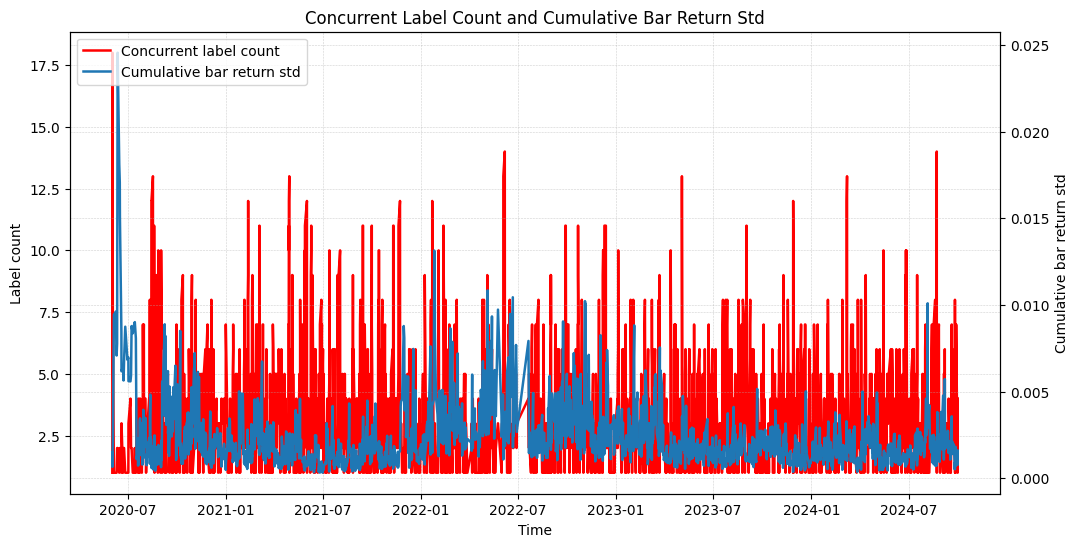

In [32]:
import matplotlib.pyplot as plt
fig, ax_left = plt.subplots(figsize=(12, 6))

intersection_idx=daily_volatility.index.intersection(concurrent_label_cnt.index)
line1, = ax_left.plot(intersection_idx,
                      concurrent_label_cnt.loc[intersection_idx],
                      lw=1.8,
                      label='Concurrent label count', color="red")
ax_left.set_xlabel('Time')
ax_left.set_ylabel('Label count')
ax_left.grid(True, which='both', ls='--', lw=0.4, alpha=0.6)

ax_right = ax_left.twinx()
line2, = ax_right.plot(intersection_idx,
                      daily_volatility.loc[intersection_idx],
                      lw=1.8,
                      label='Cumulative bar return std')
ax_right.set_ylabel('Cumulative bar return std')
ax_right.grid(True, which='both', ls='--', lw=0.4, alpha=0.6)
ax_right.legend([line1, line2], [line1.get_label(), line2.get_label()], loc='upper left')
plt.title('Concurrent Label Count and Cumulative Bar Return Std')
plt.show()

(d) Produce a scatterplot of the number of concurrent labels (x-axis) and the

exponentially weighted moving standard deviation of returns (y-axis). Can

you appreciate a relationship?


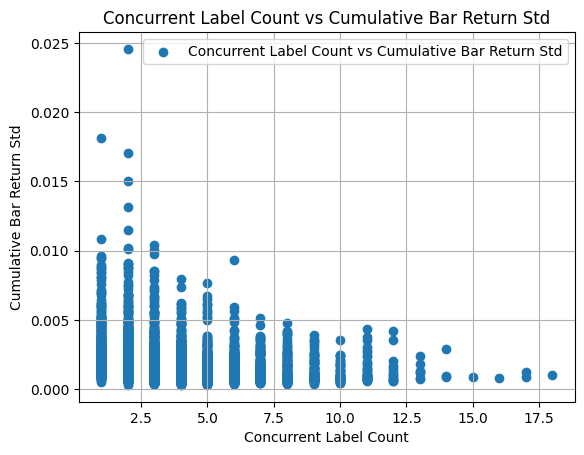

In [33]:
plt.scatter(concurrent_label_cnt.loc[intersection_idx],daily_volatility.loc[intersection_idx] , label='Concurrent Label Count vs Cumulative Bar Return Std')
plt.xlabel('Concurrent Label Count')
plt.ylabel('Cumulative Bar Return Std')
plt.title('Concurrent Label Count vs Cumulative Bar Return Std')
plt.grid(True)
plt.legend()
plt.show()

4.2 Using the function mpSampleTW,compute the average uniqueness of each label.
What is the first-order serial correlation, AR(1), of this time series? Is it statisti-
cally significant? Why?

In [34]:
def get_average_label_uniquenesss(t1:pd.Series, num_concurrent_label:pd.Series, molecule:None)-> pd.Series:
    if molecule is not None:
        weight=pd.Series(index=molecule)
    else:
        weight=pd.Series(index=t1.index)
    for t_in, t_out in t1.loc[weight.index].items():
        weight.loc[t_in]=(1.0/num_concurrent_label.loc[t_in:t_out]).mean()
    return weight

label_uniqueness=get_average_label_uniquenesss(t1, concurrent_label_cnt, None)
print('auto_corr',label_uniqueness.autocorr(lag=1))

from statsmodels.stats.diagnostic import acorr_ljungbox
lb = acorr_ljungbox(label_uniqueness, lags=[1], return_df=True)
print('Ljung-Box', lb) 



auto_corr 0.5494266604554677
Ljung-Box        lb_stat      lb_pvalue
1  1072.092608  3.841208e-235


통계적으로 유의한 1차 자기상관을 가진다는 것을 알 수 있다.

4.3 Fit a random forest to a financial dataset where $I^{-1} \sum_{i=1}^l \overline{u_i} << 1$

2020-06-02 13:37:00   2020-06-02 13:40:00
2020-06-02 13:40:00   2020-06-02 13:48:00
2020-06-02 13:42:00   2020-06-02 13:59:00
2020-06-02 13:45:00   2020-06-02 14:00:00
2020-06-02 13:47:00   2020-06-02 13:57:00
                              ...        
2024-09-30 15:55:00                   NaT
2024-09-30 15:56:00                   NaT
2024-09-30 15:57:00                   NaT
2024-09-30 15:58:00                   NaT
2024-09-30 15:59:00                   NaT
Name: t1, Length: 391436, dtype: datetime64[ns]


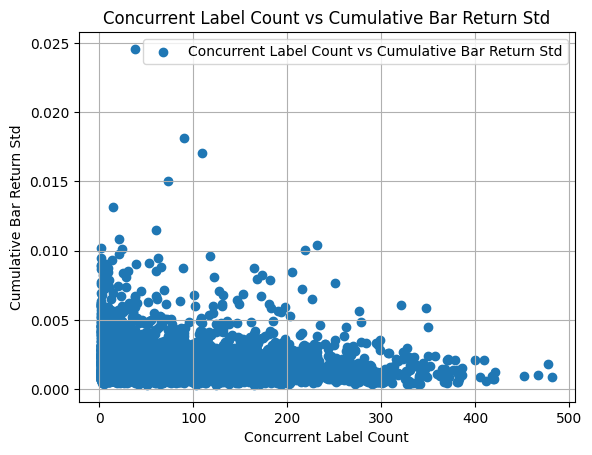

average label uniqueness 0.016021711800145708


In [50]:

events=get_events(dollar_bars['Close'], daily_volatility.index, (1,1), daily_volatility, t1=vertical_barrier)
t1=events['t1']
print(t1)
concurrent_label_cnt=num_concurrent_label(dollar_bars.index, t1, None)
label_uniqueness=get_average_label_uniquenesss(t1, concurrent_label_cnt, None)

plt.scatter(concurrent_label_cnt.loc[intersection_idx],daily_volatility.loc[intersection_idx] , label='Concurrent Label Count vs Cumulative Bar Return Std')
plt.xlabel('Concurrent Label Count')
plt.ylabel('Cumulative Bar Return Std')
plt.title('Concurrent Label Count vs Cumulative Bar Return Std')
plt.grid(True)
plt.legend()
plt.show()

print('average label uniqueness', label_uniqueness.mean())

                          ret  bin
2020-06-02 13:37:00  0.001057  1.0
2020-06-02 13:40:00 -0.001160 -1.0
2020-06-02 13:42:00  0.001255  1.0
2020-06-02 13:45:00  0.001778  1.0
2020-06-02 13:47:00  0.001524  1.0
...                       ...  ...
2024-09-30 15:48:00  0.001550  1.0
2024-09-30 15:49:00  0.001763  1.0
2024-09-30 15:50:00  0.001697  1.0
2024-09-30 15:51:00  0.001896  1.0
2024-09-30 15:53:00  0.001907  1.0

[391429 rows x 2 columns]


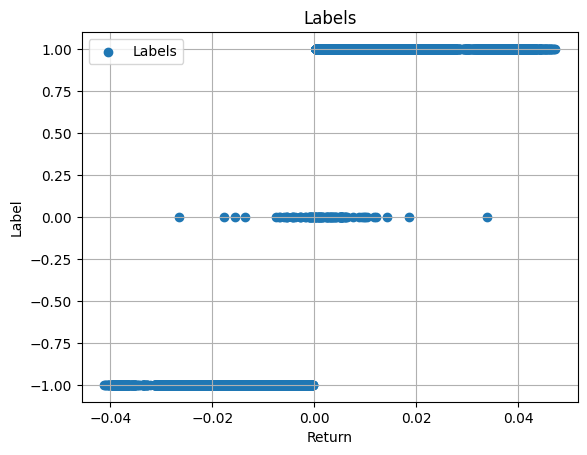

In [59]:
def get_bins(events: pd.DataFrame, close: pd.Series, vertical_barrier: pd.Series):
    """
    Get the bins for the events.

    :param events: pd.DataFrame The events dataframe containing the event times and labels.
    close: pd.Series The close price series.
    t1: pd.Series
        The vertical barrier time series.
    :return: pd.DataFrame
        A dataframe with the event times and the corresponding bins.
        (0: touch vertical barrier, 1: profit taking, -1: stop loss)
    """
    # check vertical barrier touch first
    vt_time_stamp = pd.DatetimeIndex([])
    for loc, touch_time in events["t1"].dropna().items():
        if (loc in vertical_barrier.index) and vertical_barrier.loc[loc] == touch_time:
            vt_time_stamp = vt_time_stamp.append(pd.DatetimeIndex([loc]))

    # check event time
    events_ = events.dropna(subset=["t1"])
    price_idx = events_.index.union(events_["t1"].values).drop_duplicates()
    price = close.reindex(price_idx, method="bfill")
    ret = pd.DataFrame(index=events_.index)
    ret["ret"] = price.loc[events_["t1"]].values / price.loc[events_.index].values - 1
    ret["bin"] = np.sign(ret["ret"])
    ret.loc[vt_time_stamp, "bin"] = 0
    return ret

labels=get_bins(events, dollar_bars['Close'], vertical_barrier);
print(labels)
plt.scatter(labels['ret'], labels['bin'], label='Labels')
plt.xlabel('Return')
plt.ylabel('Label')
plt.title('Labels')
plt.grid(True)
plt.legend()
plt.show()

(a) What is the mean out-of-bag accuracy

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X=pd.DataFrame(index=labels.index)
dollar_bars_return=dollar_bars['Close'].pct_change()
for i in range(1, 11):
    X['ret_lag_{}'.format(i)]=dollar_bars_return.shift(i).loc[X.index]
X=X.dropna(how='any')
print(X)
y=labels.loc[X.index, 'bin']

X_train,X_test,y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True)
rf.fit(X_train, y_train)
print('OOB score:', rf.oob_score_)
print(classification_report(y_test, rf.predict(X_test)))




                     ret_lag_1  ret_lag_2  ret_lag_3  ret_lag_4  ret_lag_5  \
2020-06-02 13:37:00   0.002768  -0.000376  -0.000167  -0.000193   0.000435   
2020-06-02 13:40:00  -0.002356   0.002768  -0.000376  -0.000167  -0.000193   
2020-06-02 13:42:00   0.001057  -0.002356   0.002768  -0.000376  -0.000167   
2020-06-02 13:45:00  -0.000268   0.001057  -0.002356   0.002768  -0.000376   
2020-06-02 13:47:00   0.000092  -0.000268   0.001057  -0.002356   0.002768   
...                        ...        ...        ...        ...        ...   
2024-09-30 15:48:00   0.000637  -0.000024   0.000361   0.000455  -0.000082   
2024-09-30 15:49:00   0.000136   0.000637  -0.000024   0.000361   0.000455   
2024-09-30 15:50:00  -0.000212   0.000136   0.000637  -0.000024   0.000361   
2024-09-30 15:51:00   0.001173  -0.000212   0.000136   0.000637  -0.000024   
2024-09-30 15:53:00   0.000327   0.000262   0.001173  -0.000212   0.000136   

                     ret_lag_6  ret_lag_7  ret_lag_8  ret_lag_9

/opt/homebrew/anaconda3/envs/AFML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AFML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AFML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

(b) What is the mean accuracy of k-fold cross-validation (without shuffling) on
thesame dataset?

In [63]:
from sklearn.model_selection import KFold, cross_val_score
kf = KFold(n_splits=5, shuffle=False)
cv_scores=cross_val_score(rf, X, y, cv=kf)
print('Cross-validation scores:', cv_scores)
print('Mean cross-validation score:', cv_scores.mean())


Cross-validation scores: [0.50574815 0.50401093 0.49988504 0.5082007  0.50940793]
Mean cross-validation score: 0.5054505515875956


(c) Why is out-of-bag accuracy so much higher than cross-validation accuracy?
Which one is more correct / less biased? What is the source of this bias?

4.4 Modify the code in Section 4.7 to apply an exponential time-decay factor.

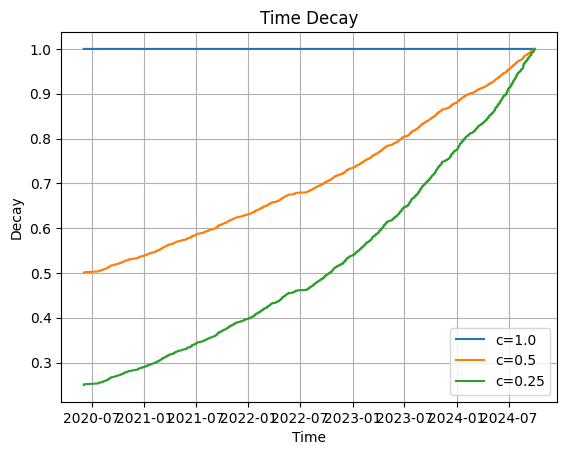

In [68]:
def get_time_decay(uniqueness:pd.Series, c:float=1.0):
    decay_factor=uniqueness.sort_index().cumsum()
    if not (0 < c <=1):
        raise ValueError('c must be in (0, 1]')
    b=-np.log(c)/decay_factor.iloc[-1]
    a=-b*decay_factor.iloc[-1]
    return np.exp(a+b*decay_factor)

decay_1=get_time_decay(label_uniqueness, 1)
decay_0_5=get_time_decay(label_uniqueness, 0.5)
decay_0_25=get_time_decay(label_uniqueness, 0.25)
plt.plot(decay_1.index, decay_1.values, label='c=1.0')
plt.plot(decay_0_5.index, decay_0_5.values, label='c=0.5')
plt.plot(decay_0_25.index, decay_0_25.values, label='c=0.25')
plt.xlabel('Time')
plt.ylabel('Decay')
plt.title('Time Decay')
plt.grid(True)
plt.legend()
plt.show()
